In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def dist(x1, y1, x2, y2):
    return math.sqrt(math.pow(x2 - x1, 2) + math.pow(y2 - y1, 2))

In [3]:
def draw_circle (x, y, r, circleColor):
    xs = []
    ys = []
    angles = np.arange(0, 2.2*np.pi, 0.2)        
    
    for angle in angles :
        xs.append(r*np.cos(angle) + x)
        ys.append(r*np.sin(angle) + y)
        
    plt.plot(xs, ys, '-', color = circleColor)
    
def sign(num):  
    if num >= 0:
        return 1
    else:
        return -1

In [134]:
class PurePursuit_Pilot(object):
    # debug ver
    
    def __init__(
            self,
            throttle: float,
            lookahead_distance: float,
            use_constant_throttle: bool = False,
            min_throttle: float = None):
        self.throttle = throttle
        self.use_constant_throttle = use_constant_throttle
        self.variable_speed_multiplier = 1.0
        self.min_throttle = min_throttle if min_throttle is not None else throttle

        self.ld = lookahead_distance
        self.axel_dist = 1

    def run(self, path: list, pos_x, pos_y, heading, throttles: list, closest_pt_idx: int) -> tuple:
        ### CALCULATE STEERING
        # find dist of closest point; if within ld, find intersections; else use closest point as goal point
        #
        goal_dist = dist(pos_x, pos_y, path[closest_pt_idx][0], path[closest_pt_idx][1])
        print(f'goal dist: {goal_dist}')
        if goal_dist < self.ld:

            # check next point along path; keep moving until furthest point within ld is found
            i = 0
            line_found = False
            while not line_found:
                # calc distance for next point
                i += 1
                if dist(pos_x, pos_y, path[(closest_pt_idx + i) % len(path)][0], path[(closest_pt_idx + i) % len(path)][1]) > self.ld:
                    # if dist exceeds lookahead distance, go back one point
                    i -= 1
                    line_found = True
                print(f'goal dist: {goal_dist}')
                # loop terminates if dist exceeds ld; keep last valid index
            
            # set line segment where goal point solution exists
            print(f'closest_idx = {closest_pt_idx}, i = {i}')
            a = path[(closest_pt_idx + i) % len(path)]
            b = path[(closest_pt_idx + i + 1) % len(path)]
            print(f'using line ({a},{b})')
            # calculate intersection solution
            dx = (b[0] - pos_x) - (a[0] - pos_x)
            dy = (b[1] - pos_y) - (a[1] - pos_y)
            dr = math.sqrt(dx**2 + dy**2) + 1e-5
            D = (a[0] - pos_x)*(b[1] - pos_y) - (b[0] - pos_x)*(a[1] - pos_y)
            discrim = (self.ld**2) * (dr**2) - (D**2)
            if discrim >= 0:
                # solutions exist
                #print(f'discrim: {discrim}')
                # calculate the solutions
                sol_x1 = (D * dy + sign(dy) * dx * math.sqrt(discrim)) / dr**2
                sol_x2 = (D * dy - sign(dy) * dx * math.sqrt(discrim)) / dr**2
                sol_y1 = (- D * dx + abs(dy) * math.sqrt(discrim)) / dr**2
                sol_y2 = (- D * dx - abs(dy) * math.sqrt(discrim)) / dr**2
                # adjust offsets
                sol_x1 += pos_x
                sol_x2 += pos_x
                sol_y1 += pos_y
                sol_y2 += pos_y
                print(f'possible solutions: ({sol_x1}, {sol_y1}) and ({sol_x2}, {sol_y2})')

                # find distance between each solution and next point; use one with smallest dist (furthest along point)
                dist_1 = dist(sol_x1, sol_y1, path[(closest_pt_idx + i + 1) % len(path)][0], path[(closest_pt_idx + i + 1) % len(path)][1])
                dist_2 = dist(sol_x2, sol_y2, path[(closest_pt_idx + i + 1) % len(path)][0], path[(closest_pt_idx + i + 1) % len(path)][1])

                # use solution with lower dist as goal point, but only if solution exists within bounds of line
                if dist_1 < dist_2: #and (sol_x1 >= a[0] and sol_x1 <= b[0]) and (sol_y1 >= a[1] and sol_y1 <= b[1]):
                    goal_point = [sol_x1, sol_y1]
                elif dist_2 < dist_1:# and (sol_x2 >= a[0] and sol_x2 <= b[0]) and (sol_y2 >= a[1] and sol_y2 <= b[1]):
                    goal_point = [sol_x2, sol_y2]
                else:
                    print(f'both points out of track bounds; default to closest point {path[closest_pt_idx]}')
                    goal_point = path[closest_pt_idx]
            else:
                # no solution exists; default to closest
                print(f'negative discriminant; default to closest point {path[closest_pt_idx]}')
                goal_point = path[closest_pt_idx]

        else:
            # closest point is not within ld circle; use closest as goal point
            print(f'closest out of range; using {path[(closest_pt_idx + 1) % len(path)]} at dist {goal_dist}')
            goal_point = path[(closest_pt_idx + 1) % len(path)]
        # plug goal point into formula for steering angle

        # set steering angle
        # alpha is angle difference between current heading and heading towards goal point
        # TODO: Need to check if calculation works in each quadrant
        #####print(f'total angle: {math.acos((goal_point[0] - pos_x) / math.sqrt((goal_point[0] - pos_x)**2 + (goal_point[1] - pos_y)**2)) * (180/math.pi)}')
        alpha = math.acos((goal_point[0] - pos_x) / (math.sqrt((goal_point[0] - pos_x)**2 + (goal_point[1] - pos_y)**2) + 1e-5)) - heading
        # ensure steering is along arc
       # alpha = math.atan((2 * self.axel_dist*math.sin(alpha)) / self.ld)
        # if goalpoint is south of position, adjust
        if pos_y - goal_point[1] > 0:
            steer = alpha - 2*math.pi
        else:
            steer = alpha
        #steer=alpha
        print(f'goal point: {goal_point}')
        print(f'steering angle: {steer*(180/math.pi)}')
        ### END STEERING CALCULATION
        

        if self.use_constant_throttle or throttles is None or closest_pt_idx is None:
            throttle = self.throttle
        elif throttles[closest_pt_idx] * self.variable_speed_multiplier < self.min_throttle:
            throttle = self.min_throttle
        else:
            throttle = throttles[closest_pt_idx] * self.variable_speed_multiplier
        return goal_point, steer, throttle

In [21]:
class PurePursuit_Pilot(object):
    # reg

    def __init__(
            self,
            throttle: float,
            lookahead_distance: float,
            use_constant_throttle: bool = False,
            min_throttle: float = None):
        self.throttle = throttle
        self.use_constant_throttle = use_constant_throttle
        self.variable_speed_multiplier = 1.0
        self.min_throttle = min_throttle if min_throttle is not None else throttle

        self.ld = lookahead_distance
        self.axel_dist = 1

    def run(self, path: list, pos_x, pos_y, heading, throttles: list, closest_pt_idx: int) -> tuple:
        ### CALCULATE STEERING
        # find dist of closest point; if within ld, find intersections; else use closest point as goal point
        #
        goal_dist = dist(pos_x, pos_y, path[closest_pt_idx][0], path[closest_pt_idx][1])
        if goal_dist < self.ld:

            # check next point along path; keep moving until furthest point within ld is found
            i = 0
            line_found = False
            while not line_found:
                # calc distance for next point
                i += 1
                if dist(pos_x, pos_y, path[(closest_pt_idx + i) % len(path)][0], path[(closest_pt_idx + i) % len(path)][1]) > self.ld:
                    # if dist exceeds lookahead distance, go back one point
                    i -= 1
                    line_found = True
                # loop terminates if dist exceeds ld; keep last valid index
            
            # set line segment where goal point solution exists
            a = path[(closest_pt_idx + i) % len(path)]
            b = path[(closest_pt_idx + i + 1) % len(path)]
            # calculate intersection solution
            dx = (b[0] - pos_x) - (a[0] - pos_x)
            dy = (b[1] - pos_y) - (a[1] - pos_y)
            dr = math.sqrt(dx**2 + dy**2) + 1e-5
            D = (a[0] - pos_x)*(b[1] - pos_y) - (b[0] - pos_x)*(a[1] - pos_y)
            discrim = (self.ld**2) * (dr**2) - (D**2)
            if discrim >= 0:
                # solutions exist
                #print(f'discrim: {discrim}')
                # calculate the solutions
                sol_x1 = (D * dy + sign(dy) * dx * math.sqrt(discrim)) / dr**2
                sol_x2 = (D * dy - sign(dy) * dx * math.sqrt(discrim)) / dr**2
                sol_y1 = (- D * dx + abs(dy) * math.sqrt(discrim)) / dr**2
                sol_y2 = (- D * dx - abs(dy) * math.sqrt(discrim)) / dr**2
                # adjust offsets
                sol_x1 += pos_x
                sol_x2 += pos_x
                sol_y1 += pos_y
                sol_y2 += pos_y

                # find distance between each solution and next point; use one with smallest dist (furthest along point)
                dist_1 = dist(sol_x1, sol_y1, path[(closest_pt_idx + i + 1) % len(path)][0], path[(closest_pt_idx + i + 1) % len(path)][1])
                dist_2 = dist(sol_x2, sol_y2, path[(closest_pt_idx + i + 1) % len(path)][0], path[(closest_pt_idx + i + 1) % len(path)][1])

                # use solution with lower dist as goal point, but only if solution exists within bounds of line
                if dist_1 < dist_2: #and (sol_x1 >= a[0] and sol_x1 <= b[0]) and (sol_y1 >= a[1] and sol_y1 <= b[1]):
                    goal_point = [sol_x1, sol_y1]
                elif dist_2 < dist_1:# and (sol_x2 >= a[0] and sol_x2 <= b[0]) and (sol_y2 >= a[1] and sol_y2 <= b[1]):
                    goal_point = [sol_x2, sol_y2]
                else:
                    goal_point = path[closest_pt_idx]
            else:
                # no solution exists; default to closest
                goal_point = path[closest_pt_idx]

        else:
            # closest point is not within ld circle; use closest as goal point
            goal_point = path[(closest_pt_idx + 1) % len(path)]
        # plug goal point into formula for steering angle

        # set steering angle
        # alpha is angle difference between current heading and heading towards goal point
        # TODO: Need to check if calculation works in each quadrant
        #####print(f'total angle: {math.acos((goal_point[0] - pos_x) / math.sqrt((goal_point[0] - pos_x)**2 + (goal_point[1] - pos_y)**2)) * (180/math.pi)}')
        alpha = math.acos((goal_point[0] - pos_x) / (math.sqrt((goal_point[0] - pos_x)**2 + (goal_point[1] - pos_y)**2) + 1e-5))
        # if goalpoint is north of position
        if pos_y - goal_point[1] > 0:
            # south-facing; rotate by 180
            steer = abs(heading + (alpha - heading - 2*math.pi)) - heading
        else:
            # north-facing
            steer = alpha - heading
        #steer=alpha
        ### END STEERING CALCULATION
        

        if self.use_constant_throttle or throttles is None or closest_pt_idx is None:
            throttle = self.throttle
        elif throttles[closest_pt_idx] * self.variable_speed_multiplier < self.min_throttle:
            throttle = self.min_throttle
        else:
            throttle = throttles[closest_pt_idx] * self.variable_speed_multiplier
        return goal_point, steer, throttle

In [5]:
pilot = PurePursuit_Pilot(1, .5)

In [93]:
path = [(.5, .5), (1,1), (1.5,3), (2, 4), (2,6)]
pos_x = 0
pos_y = 0
speed=.2
heading = 0
throttles = [1, 1, 1, 1, 1, 1]
closest_idx = 0

In [94]:
goal, steer, throttle = pilot.run(path, pos_x, pos_y, heading, throttles, closest_idx)

goal dist: 0.7071067811865476
closest out of range; using (0.5, 0.5) at dist 0.7071067811865476
goal point: (0.5, 0.5)
steering angle: 45.00081026749625


In [95]:
#plt.scatter([pos_x, 0.7071067811865475, -0.7071067811865475], [pos_y, 0.7071067811865475, -0.7071067811865475])
#plt.plot([1, .5], [1, .5])
#draw_circle(0, 0, 1, 'green')
#plt.show()

In [96]:
# adjust heading
heading += steer
# move based on new heading
pos_x += math.cos(heading)*speed
pos_y += math.sin(heading)*speed

In [97]:
goal, steer, throttle = pilot.run(path, pos_x, pos_y, heading, throttles, closest_idx)

goal dist: 0.5071067812144342
closest out of range; using (0.5, 0.5) at dist 0.5071067812144342
goal point: (0.5, 0.5)
steering angle: 3.1506256619109452e-09


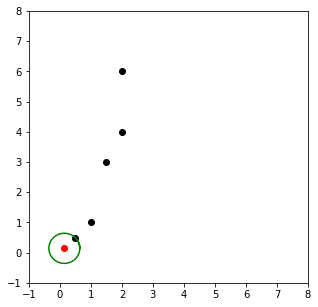

In [98]:
fig = plt.figure(figsize=(5,5))
plt.scatter([x for x,y in path], [y for x,y in path], color='black', label='path')
plt.scatter(pos_x, pos_y, color='red', label='current position')
#plt.plot([1, .5], [1, .5], color='black', label='path segment')
draw_circle(pos_x, pos_y, .5, 'green')
plt.xlim(-1,8)
plt.ylim(-1,8)
plt.show()

In [99]:
# adjust heading
heading += steer
# move based on new heading
pos_x += math.cos(heading)*speed
pos_y += math.sin(heading)*speed

In [100]:
goal, steer, throttle = pilot.run(path, pos_x, pos_y, heading, throttles, closest_idx)

goal dist: 0.30710678127864316
goal dist: 0.30710678127864316
closest_idx = 0, i = 0
using line ((0.5, 0.5),(1, 1))
possible solutions: (0.6363911029745613, 0.6363911032008263) and (-0.07070567830815461, -0.07070567808188954)
goal point: [0.6363911029745613, 0.6363911032008263]
steering angle: -0.00031255339074531444


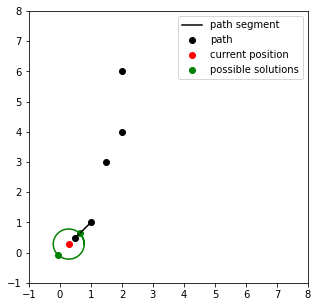

In [101]:
fig = plt.figure(figsize=(5,5))
plt.scatter([x for x,y in path], [y for x,y in path], color='black', label='path')
plt.scatter(pos_x, pos_y, color='red', label='current position')
plt.scatter([0.6363871031873936, -0.07070967814057344], [0.6363951030332451, -0.07070167829472185], color='green', label='possible solutions')
plt.plot([.5, 1], [.5, 1], color='black', label='path segment')
draw_circle(pos_x, pos_y, .5, 'green')
plt.xlim(-1,8)
plt.ylim(-1,8)
plt.legend()
plt.show()

In [102]:
# adjust heading
heading += steer
# move based on new heading
pos_x += math.cos(heading)*speed
pos_y += math.sin(heading)*speed

In [103]:
goal, steer, throttle = pilot.run(path, pos_x, pos_y, heading, throttles, closest_idx)

goal dist: 0.10710678148931775
goal dist: 0.10710678148931775
closest_idx = 0, i = 0
using line ((0.5, 0.5),(1, 1))
possible solutions: (0.777812459155756, 0.777812459451514) and (0.07071567790510491, 0.07071567820086289)
goal point: [0.777812459155756, 0.777812459451514]
steering angle: -0.00019907612371187073


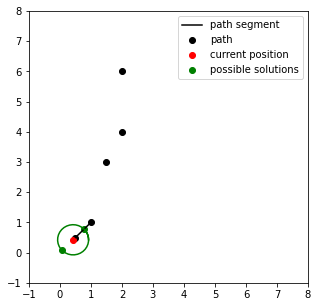

In [104]:
fig = plt.figure(figsize=(5,5))
plt.scatter([x for x,y in path], [y for x,y in path], color='black', label='path')
plt.scatter(pos_x, pos_y, color='red', label='current position')
plt.scatter([0.7778056310141472, 0.07070884968618035], [0.7778192876245436, 0.07072250629657656], color='green', label='possible solutions')
plt.plot([.5, 1], [.5, 1], color='black', label='path segment')
draw_circle(pos_x, pos_y, .5, 'green')
plt.xlim(-1,8)
plt.ylim(-1,8)
plt.legend()
plt.show()

In [105]:
# adjust heading
heading += steer
# move based on new heading
pos_x += math.cos(heading)*speed
pos_y += math.sin(heading)*speed

In [106]:
goal, steer, throttle = pilot.run(path, pos_x, pos_y, heading, throttles, closest_idx)

goal dist: 0.09289321914629528
goal dist: 0.09289321914629528
closest_idx = 0, i = 0
using line ((0.5, 0.5),(1, 1))
possible solutions: (0.9192338153586271, 0.9192338156960824) and (0.21213703413131335, 0.21213703446876864)
goal point: [0.9192338153586271, 0.9192338156960824]
steering angle: -0.00011944998545499872


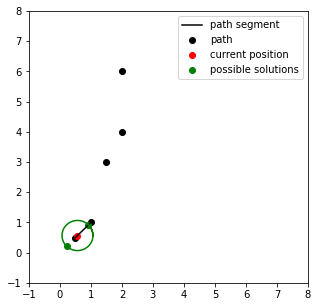

In [107]:
fig = plt.figure(figsize=(5,5))
plt.scatter([x for x,y in path], [y for x,y in path], color='black', label='path')
plt.scatter(pos_x, pos_y, color='red', label='current position')
plt.scatter([0.919224158840901, 0.2121273775129341], [0.9192434722158421, 0.2121466908878752], color='green', label='possible solutions')
plt.plot([.5, 1], [.5, 1], color='black', label='path segment')
draw_circle(pos_x, pos_y, .5, 'green')
plt.xlim(-1,8)
plt.ylim(-1,8)
plt.legend()
plt.show()

In [108]:
# adjust heading
heading += steer
# move based on new heading
pos_x += math.cos(heading)*speed
pos_y += math.sin(heading)*speed

In [109]:
goal, steer, throttle = pilot.run(path, pos_x, pos_y, heading, throttles, closest_idx)

goal dist: 0.2928932189024021
goal dist: 0.2928932189024021
goal dist: 0.2928932189024021
closest_idx = 0, i = 1
using line ((1, 1),(1.5, 3))
possible solutions: (1.0235538634205326, 1.0942239783757182) and (0.8041542578147595, 0.21662555595262584)
goal point: [1.0235538634205326, 1.0942239783757182]
steering angle: 5.735608955452785


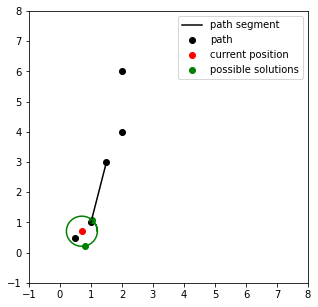

In [110]:
fig = plt.figure(figsize=(5,5))
plt.scatter([x for x,y in path], [y for x,y in path], color='black', label='path')
plt.scatter(pos_x, pos_y, color='red', label='current position')
plt.scatter([1.0235538634205326, 0.8041542578147595], [1.0942239783757182, 0.21662555595262584], color='green', label='possible solutions')
plt.plot([1, 1.5], [1, 3], color='black', label='path segment')
draw_circle(pos_x, pos_y, .5, 'green')
plt.xlim(-1,8)
plt.ylim(-1,8)
plt.legend()
plt.show()

In [111]:
# adjust heading
heading += steer
# move based on new heading
pos_x += math.cos(heading)*speed
pos_y += math.sin(heading)*speed

In [112]:
goal, steer, throttle = pilot.run(path, pos_x, pos_y, heading, throttles, 1)

goal dist: 0.2161419521768463
goal dist: 0.2161419521768463
closest_idx = 1, i = 0
using line ((1, 1),(1.5, 3))
possible solutions: (1.0749696281125005, 1.2998836274010122) and (0.8405010416884887, 0.3620092817049643)
goal point: [1.0749696281125005, 1.2998836274010122]
steering angle: 10.410677461816528


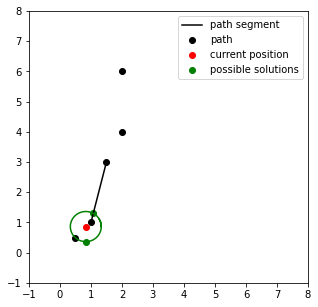

In [113]:
fig = plt.figure(figsize=(5,5))
plt.scatter([x for x,y in path], [y for x,y in path], color='black', label='path')
plt.scatter(pos_x, pos_y, color='red', label='current position')
plt.scatter([1.0749696281125005, 0.8405010416884887], [1.2998836274010122, 0.3620092817049643], color='green', label='possible solutions')
plt.plot([1, 1.5], [1, 3], color='black', label='path segment')
draw_circle(pos_x, pos_y, .5, 'green')
plt.xlim(-1,8)
plt.ylim(-1,8)
plt.legend()
plt.show()

In [114]:
# adjust heading
heading += steer
# move based on new heading
pos_x += math.cos(heading)*speed
pos_y += math.sin(heading)*speed

In [115]:
goal, steer, throttle = pilot.run(path, pos_x, pos_y, heading, throttles, 1)

goal dist: 0.0790669869954996
goal dist: 0.0790669869954996
closest_idx = 1, i = 0
using line ((1, 1),(1.5, 3))
possible solutions: (1.1244608142398789, 1.4978463260252692) and (0.8847989812383165, 0.5391989940190198)
goal point: [1.1244608142398789, 1.4978463260252692]
steering angle: 5.9906495042641135


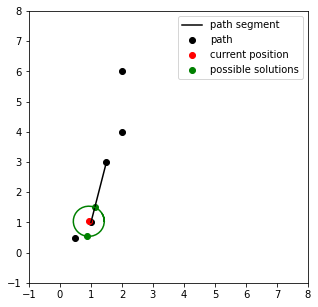

In [116]:
fig = plt.figure(figsize=(5,5))
plt.scatter([x for x,y in path], [y for x,y in path], color='black', label='path')
plt.scatter(pos_x, pos_y, color='red', label='current position')
plt.scatter([1.1244608142398789, 0.8847989812383165], [1.4978463260252692, 0.5391989940190198], color='green', label='possible solutions')
plt.plot([1, 1.5], [1, 3], color='black', label='path segment')
draw_circle(pos_x, pos_y, .5, 'green')
plt.xlim(-1,8)
plt.ylim(-1,8)
plt.legend()
plt.show()

In [126]:
# adjust heading
heading += steer
# move based on new heading
pos_x += math.cos(heading)*speed
pos_y += math.sin(heading)*speed

In [127]:
goal, steer, throttle = pilot.run(path, pos_x, pos_y, heading, throttles, 1)

goal dist: 0.8015372677219427
closest out of range; using (1, 1) at dist 0.8015372677219427
goal point: (1, 1)
steering angle: -6.050197884735668


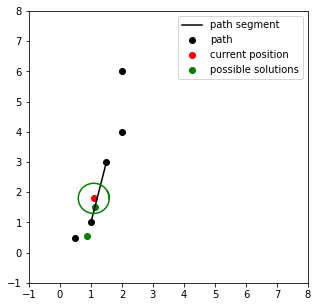

In [128]:
fig = plt.figure(figsize=(5,5))
plt.scatter([x for x,y in path], [y for x,y in path], color='black', label='path')
plt.scatter(pos_x, pos_y, color='red', label='current position')
plt.scatter([1.1244608142398789, 0.8847989812383165], [1.4978463260252692, 0.5391989940190198], color='green', label='possible solutions')
plt.plot([1, 1.5], [1, 3], color='black', label='path segment')
draw_circle(pos_x, pos_y, .5, 'green')
plt.xlim(-1,8)
plt.ylim(-1,8)
plt.legend()
plt.show()

In [10]:
# graph positions with short custom track
positions = []
path = [(.5, .5), (1,1), (1.5,3), (2, 4), (2,6), (1,8)]
pos_x = 0
pos_y = 0
speed=.2
heading = 0
throttles = [1, 1, 1, 1, 1, 1, 1]
closest_idx = 0
pilot = PurePursuit_Pilot(1, .7)
for i in range(55):
    print(f'iteration {i}')
    # run pilot
    goal, steer, throttle = pilot.run(path, pos_x, pos_y, heading, throttles, closest_idx)
    # adjust heading
    heading += steer
    heading = abs(heading)
    # move based on new heading
    pos_x += math.cos(heading)*speed
    pos_y += math.sin(heading)*speed
    positions += [(pos_x, pos_y)]
    # update closest idx
    
    # update closest_idx; only search next 3 points
    for ip in range(2):
        # if dist is lower than current, set new
        if dist(pos_x, pos_y, path[(ip + closest_idx) % len(path)][0], path[(ip + closest_idx) % len(path)][1]) < dist(pos_x, pos_y, path[closest_idx][0], path[closest_idx][1]):
            closest_idx += ip
            closest_idx %= len(path)

iteration 0
goal dist: 0.7071067811865476
closest out of range; using (1, 1) at dist 0.7071067811865476
goal point: (1, 1)
steering angle: 63.66591322242673
iteration 1
goal dist: 0.5215693371214627
goal dist: 0.5215693371214627
closest_idx = 0, i = 0
using line ((0.5, 0.5),(1, 1))
possible solutions: (0.6268754925702287, 0.6268780529112226) and (-0.35891262633654475, -0.3589100659955507)
goal point: [0.6268754925702287, 0.6268780529112226]
steering angle: -49.189206502599866
iteration 2
goal dist: 0.3473794485849944
goal dist: 0.3473794485849944
closest_idx = 0, i = 0
using line ((0.5, 0.5),(1, 1))
possible solutions: (0.750061466086364, 0.7500599634046555) and (-0.23844738896877787, -0.23844889165048652)
goal point: [0.750061466086364, 0.7500599634046555]
steering angle: 57.68843136516361
iteration 3
goal dist: 0.17581863554713245
goal dist: 0.17581863554713245
closest_idx = 0, i = 0
using line ((0.5, 0.5),(1, 1))
possible solutions: (0.8751338005179692, 0.8751359502121616) and (-0.1

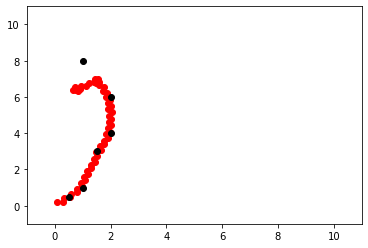

In [22]:
plt.scatter([x for x,y in positions], [y for x,y in positions], color='red', label='move')
plt.scatter([x for x,y in path], [y for x,y in path], color='black', label='path')
plt.xlim(-1,11)
plt.ylim(-1,11)
plt.show()

In [29]:
goal, steer, throttle = pilot.run(path, pos_x, pos_y, heading, throttles, closest_idx)

goal dist: 2.3008915737427373
closest out of range; using (0.5, 0.5) at dist 2.3008915737427373
goal point: (0.5, 0.5)
steering angle: -0.10811938762555814


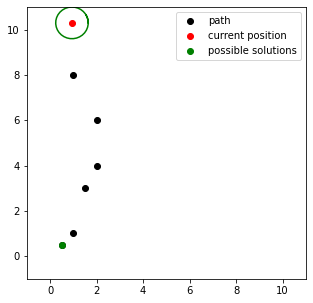

In [33]:
fig = plt.figure(figsize=(5,5))
plt.scatter([x for x,y in path], [y for x,y in path], color='black', label='path')
plt.scatter(pos_x, pos_y, color='red', label='current position')
plt.scatter([.5], [.5], color='green', label='possible solutions')
#plt.plot([1, .5], [8, .5], color='black', label='path segment')
draw_circle(pos_x, pos_y, .7, 'green')
plt.xlim(-1,11)
plt.ylim(-1,11)
plt.legend()
plt.show()

In [8]:
positions = []
goals = []
path = figeight
throttles = [1 for point in path]
pos_x = 0
pos_y = 3
heading = 0
speed = .2
closest_idx = 0
pilot = PurePursuit_Pilot(1, .7)
for ip in range(len(path)):
        # if dist is lower than current, set new
        new_dist = dist(pos_x, pos_y, path[(closest_idx + ip) % len(path)][0], path[(closest_idx + ip) % len(path)][1])
        if new_dist < dist(pos_x, pos_y, path[closest_idx][0], path[closest_idx][1]):
            #print(f'new lowest dist: {new_dist}')
            closest_idx = ip
print(f'closest starting point at index {closest_idx}: {path[closest_idx]}')
for i in range(100):
    # move set distance in direction
    pos_x += math.cos(heading)*speed
    pos_y += math.sin(heading)*speed
    positions += [(pos_x, pos_y)]
    # run pilot to find steering angle
    goal, steer, throttle = pilot.run(path, pos_x, pos_y, heading, throttles, closest_idx)
    goals += [goal]
    heading += steer
    heading = abs(heading)
    print(f'new heading: {heading * (180/math.pi)}')
    # log received
    #print(f'At ({[pos_x]}, {pos_y}), moving to {goal}, using angle {steer * (180/math.pi)}')
    # update closest_idx; only search next 3 points
    for ip in range(5):
        # if dist is lower than current, set new
        if dist(pos_x, pos_y, path[(ip + closest_idx) % len(figeight)][0], path[(ip + closest_idx) % len(figeight)][1]) < dist(pos_x, pos_y, path[closest_idx][0], path[closest_idx][1]):
            closest_idx += ip
            closest_idx %= len(figeight)

closest starting point at index 11: (0.12219854211434722, 3.951025159447454)
goal dist: 0.9542022431073971
closest out of range; using (0.05322507303208113, 3.395857967552729) at dist 0.9542022431073971
goal point: (0.05322507303208113, 3.395857967552729)
steering angle: 69.53027655622107
new heading: 69.53027655622107
goal dist: 0.3007209188707742
goal dist: 0.3007209188707742
goal dist: 0.3007209188707742
closest_idx = 12, i = 1
using line ((0.002707182429730892, 2.8500860545318574),(0.04092466086149216, 2.282685517857317))
possible solutions: (-0.06152728887430636, 3.8039024963740657) and (0.024144995323221924, 2.531958296324156)
goal point: [0.024144995323221924, 2.531958296324156]
steering angle: -298.06661277087505
new heading: 228.536336214654
goal dist: 0.3681407977240741
goal dist: 0.3681407977240741
goal dist: 0.3681407977240741
closest_idx = 12, i = 1
using line ((0.002707182429730892, 2.8500860545318574),(0.04092466086149216, 2.282685517857317))
possible solutions: (-0.0552

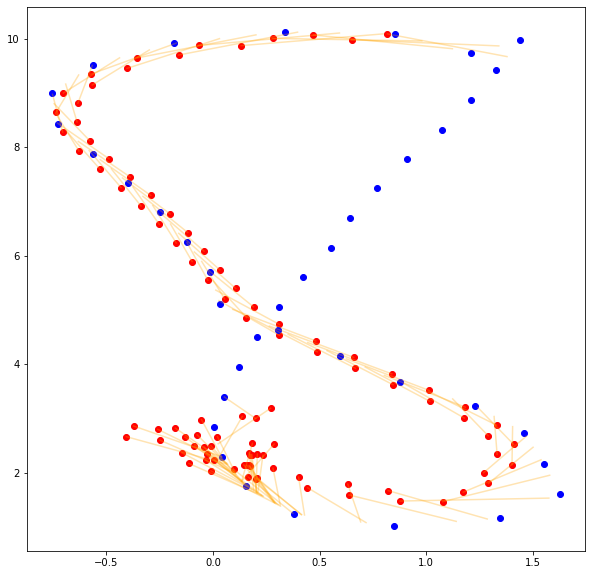

In [9]:
fig = plt.figure(figsize=(10,10))
plt.scatter([x for x,y in positions],[y for x,y in positions], color='red', label='positions')
plt.scatter([x for x,y in path], [y for x,y in path], color='blue', label='path')
for i in range(100):
    plt.plot([positions[i][0], goals[i][0]], [positions[i][1], goals[i][1]], color='orange', alpha=.3, label='goal')
plt.show()

In [54]:
positions = []
goals = []
path = figeight
throttles = [1 for point in path]
pos_x = 0
pos_y = 3
heading = 0
speed = .2
closest_idx = 0
pilot = PurePursuit_Pilot(1, .3)
for ip in range(len(path)):
        # if dist is lower than current, set new
        new_dist = dist(pos_x, pos_y, path[(closest_idx + ip) % len(path)][0], path[(closest_idx + ip) % len(path)][1])
        if new_dist < dist(pos_x, pos_y, path[closest_idx][0], path[closest_idx][1]):
            #print(f'new lowest dist: {new_dist}')
            closest_idx = ip
print(f'closest starting point at index {closest_idx}: {path[closest_idx]}')
for i in range(100):
    # move set distance in direction
    pos_x += math.cos(heading)*speed
    pos_y += math.sin(heading)*speed
    positions += [(pos_x, pos_y)]
    # run pilot to find steering angle
    goal, steer, throttle = pilot.run(path, pos_x, pos_y, heading, throttles, closest_idx)
    goals += [goal]
    heading += steer
    heading = abs(heading)
    print(f'new heading: {heading * (180/math.pi)}')
    # log received
    #print(f'At ({[pos_x]}, {pos_y}), moving to {goal}, using angle {steer * (180/math.pi)}')
    # update closest_idx; only search next 3 points
    for ip in range(5):
        # if dist is lower than current, set new
        if dist(pos_x, pos_y, path[(ip + closest_idx) % len(figeight)][0], path[(ip + closest_idx) % len(figeight)][1]) < dist(pos_x, pos_y, path[closest_idx][0], path[closest_idx][1]):
            closest_idx += ip
            closest_idx %= len(figeight)

closest starting point at index 11: (0.12219854211434722, 3.951025159447454)
goal dist: 0.9542022431073971
closest out of range; using (0.05322507303208113, 3.395857967552729) at dist 0.9542022431073971
goal point: (0.05322507303208113, 3.395857967552729)
steering angle: 110.34310565123198
new heading: 110.34310565123198
goal dist: 0.22219238467053032
goal dist: 0.22219238467053032
closest_idx = 12, i = 0
using line ((0.05322507303208113, 3.395857967552729),(0.002707182429730892, 2.8500860545318574))
possible solutions: (0.060957272601374596, 3.4793550210215125) and (0.00857245931657824, 2.9134137392540116)
NEGATIVE ANGLE DETECTED!!!!!!
goal point: [0.00857245931657824, 2.9134137392540116]
steering angle: -356.3689269315603
new heading: 246.02582128032833
goal dist: 0.3910988127613163
closest out of range; using (0.002707182429730892, 2.8500860545318574) at dist 0.3910988127613163
NEGATIVE ANGLE DETECTED!!!!!!
goal point: (0.002707182429730892, 2.8500860545318574)
steering angle: -499.

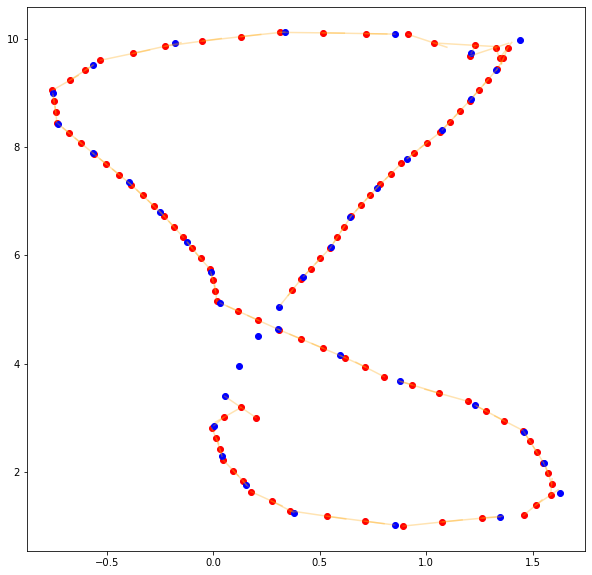

In [55]:
fig = plt.figure(figsize=(10,10))
plt.scatter([x for x,y in positions],[y for x,y in positions], color='red', label='positions')
plt.scatter([x for x,y in path], [y for x,y in path], color='blue', label='path')
for i in range(100):
    plt.plot([positions[i][0], goals[i][0]], [positions[i][1], goals[i][1]], color='orange', alpha=.3, label='goal')
plt.show()

In [98]:
positions = []
goals = []
path = figeight
throttles = [1 for point in path]
pos_x = 0
pos_y = 0
heading = 0
speed = .5
closest_idx = 0
pilot = PurePursuit_Pilot(1, 1)
for ip in range(len(path)):
        # if dist is lower than current, set new
        new_dist = dist(pos_x, pos_y, path[(closest_idx + ip) % len(path)][0], path[(closest_idx + ip) % len(path)][1])
        if new_dist < dist(pos_x, pos_y, path[closest_idx][0], path[closest_idx][1]):
            #print(f'new lowest dist: {new_dist}')
            closest_idx = ip
print(f'closest starting point at index {closest_idx}: {path[closest_idx]}')
for i in range(50):

    # run pilot to find steering angle
    goal, steer, throttle = pilot.run(path, pos_x, pos_y, heading, throttles, closest_idx)
    goals += [goal]
    heading += steer
    heading = abs(heading)
    print(f'new heading: {heading * (180/math.pi)}')
    # log received
    #print(f'At ({[pos_x]}, {pos_y}), moving to {goal}, using angle {steer * (180/math.pi)}')
    # move set distance in direction
    pos_x += math.cos(heading)*speed
    pos_y += math.sin(heading)*speed
    positions += [(pos_x, pos_y)]
    # update closest_idx; only search next 3 points
    for ip in range(10):
        # if dist is lower than current, set new
        if dist(pos_x, pos_y, path[(ip + closest_idx) % len(figeight)][0], path[(ip + closest_idx) % len(figeight)][1]) < dist(pos_x, pos_y, path[closest_idx][0], path[closest_idx][1]):
            closest_idx += ip
            closest_idx %= len(figeight)

closest starting point at index 12: (0.05322507303208113, 3.395857967552729)
goal dist: 3.3962750542602733
closest out of range; using (0.002707182429730892, 2.8500860545318574) at dist 3.3962750542602733
goal point: (0.002707182429730892, 2.8500860545318574)
steering angle: 89.94557724442288
new heading: 89.94557724442288
goal dist: 1.2577002895448333
closest out of range; using (0.37766493624076247, 1.2435652372078039) at dist 1.2577002895448333
goal point: (0.37766493624076247, 1.2435652372078039)
steering angle: -26.842637483580432
new heading: 63.102939760842446
goal dist: 0.33376369537321404
goal dist: 0.33376369537321404
goal dist: 0.33376369537321404
closest_idx = 16, i = 1
using line ((0.8511749035678804, 1.013884635118302),(1.3478598431684077, 1.163099135097582))
possible solutions: (1.2110246966613438, 1.1219956210111621) and (-0.6917544709129211, 0.5503611311694994)
goal point: [1.2110246966613438, 1.1219956210111621]
steering angle: -52.95770739574102
new heading: 10.14523

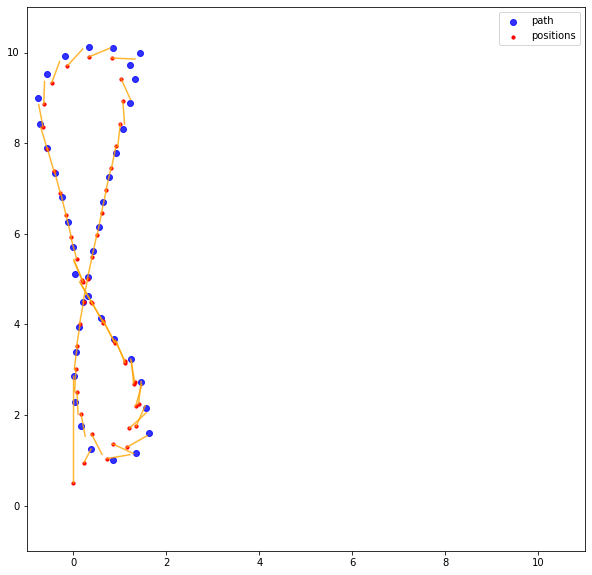

In [99]:
fig = plt.figure(figsize=(10,10))
plt.scatter([x for x,y in path], [y for x,y in path], color='blue', label='path', alpha=.8)
plt.scatter([x for x,y in positions],[y for x,y in positions], color='red', label='positions', s=10)
for i in range(50):
    plt.plot([positions[i][0], goals[i][0]], [positions[i][1], goals[i][1]], color='orange', alpha=.8)

plt.xlim(-1, 11)
plt.ylim(-1,11)
plt.legend()
plt.show()

In [39]:
figeight[2]

(1.2087122243829072, 8.883088107279036)

In [6]:
figeight = []
for line in open('8plot.csv'):
    figeight += [(eval(line)[1] + 1.5, eval(line)[0] + 10)]

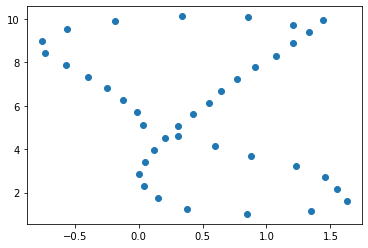

In [7]:
plt.scatter([x for x,y in figeight],[y for x,y in figeight])
plt.show()

In [77]:
montreal = []
for line in open('Montreal.csv'):
    # x,y, right_width, left_width
    montreal += [(eval(line)[0], eval(line)[1])]

In [78]:
montreal

[(0.123414, -0.739252),
 (1.226607, -5.613015),
 (2.327816, -10.486809),
 (3.419084, -15.362353),
 (4.488599, -20.24221),
 (5.524512, -25.12895),
 (6.514972, -30.025142),
 (7.44813, -34.933357),
 (8.312137, -39.856163),
 (9.097019, -44.79545),
 (9.80193, -49.749798),
 (10.428788, -54.716781),
 (10.979515, -59.693974),
 (11.456032, -64.678953),
 (11.860259, -69.669291),
 (12.194119, -74.662566),
 (12.459701, -79.656891),
 (12.659553, -84.651818),
 (12.796297, -89.647136),
 (12.872553, -94.642633),
 (12.890943, -99.638097),
 (12.854087, -104.633316),
 (12.764609, -109.62808),
 (12.625128, -114.622176),
 (12.438266, -119.615393),
 (12.206644, -124.607518),
 (11.932885, -129.598342),
 (11.619608, -134.587651),
 (11.269436, -139.575234),
 (10.88501, -144.560888),
 (10.469377, -149.544565),
 (10.025941, -154.526359),
 (9.558123, -159.506368),
 (9.069342, -164.48469),
 (8.563016, -169.461422),
 (8.042564, -174.436664),
 (7.511406, -179.410512),
 (6.972962, -184.383065),
 (6.430649, -189.35442

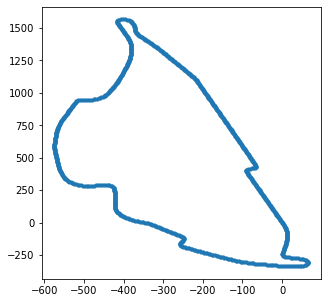

In [79]:
fig = plt.figure(figsize=(5,5))
plt.scatter([x for x,y in montreal],[y for x,y in montreal], s=10)
plt.show()

In [80]:
len(montreal)

872

In [81]:
# limit to 1/10th points
montreal = []
i = 0
for line in open('Montreal.csv'):
    # only record 1 in 20
    if i%10 == 0:
        # x,y, right_width, left_width
        montreal += [(eval(line)[0], eval(line)[1])]
    i += 1

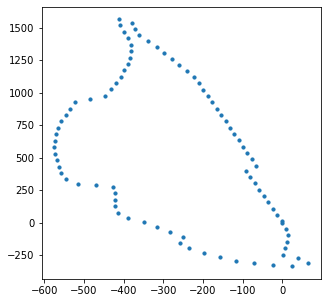

In [82]:
fig = plt.figure(figsize=(5,5))
plt.scatter([x for x,y in montreal],[y for x,y in montreal], s=10)
plt.show()

In [83]:
# pilot for montreal
goals = []
path = montreal
throttles = [1 for point in path]
pos_x = 0
pos_y = 0
heading = 0
speed = 80
closest_idx = 0
pilot = PurePursuit_Pilot(1, 50)
positions = [(pos_x, pos_y)]
for ip in range(len(path)):
        # if dist is lower than current, set new
        new_dist = dist(pos_x, pos_y, path[(closest_idx + ip) % len(path)][0], path[(closest_idx + ip) % len(path)][1])
        if new_dist < dist(pos_x, pos_y, path[closest_idx][0], path[closest_idx][1]):
            #print(f'new lowest dist: {new_dist}')
            closest_idx = ip
print(f'closest starting point at index {closest_idx}: {path[closest_idx]}')
for i in range(50):

    # run pilot to find steering angle
    goal, steer, throttle = pilot.run(path, pos_x, pos_y, heading, throttles, closest_idx)
    goals += [goal]
    heading += steer
    heading = abs(heading)
    print(f'new heading: {heading * (180/math.pi)}')
    # log received
    #print(f'At ({[pos_x]}, {pos_y}), moving to {goal}, using angle {steer * (180/math.pi)}')
    # move set distance in direction
    pos_x += math.cos(heading)*speed
    pos_y += math.sin(heading)*speed
    positions += [(pos_x, pos_y)]
    # update closest_idx; only search next 3 points
    for ip in range(10):
        # if dist is lower than current, set new
        if dist(pos_x, pos_y, path[(ip + closest_idx) % len(path)][0], path[(ip + closest_idx) % len(path)][1]) < dist(pos_x, pos_y, path[closest_idx][0], path[closest_idx][1]):
            closest_idx += ip
            closest_idx %= len(path)

closest starting point at index 0: (0.123414, -0.739252)
goal dist: 0.7494828449671147
goal dist: 0.7494828449671147
closest_idx = 0, i = 0
using line ((0.123414, -0.739252),(9.80193, -49.749798))
possible solutions: (-9.708558184802033, 49.048373032272586) and (9.665108290038637, -49.0569534406946)
goal point: [9.665108290038637, -49.0569534406946]
steering angle: -281.1455578859463
new heading: 281.1455578859463
goal dist: 29.293785070317846
goal dist: 29.293785070317846
goal dist: 29.293785070317846
closest_idx = 1, i = 1
using line ((12.890943, -99.638097),(10.469377, -149.544565))
possible solutions: (16.34276732355414, -28.498871705818587) and (11.498576744472054, -128.3336241432337)
goal point: [11.498576744472054, -128.3336241432337]
steering angle: -546.5965413026308
new heading: 265.4509834166846
goal dist: 41.2276404814081
goal dist: 41.2276404814081
closest_idx = 4, i = 0
using line ((5.348095, -199.293934),(1.482538, -249.074091))
possible solutions: (12.410313879131776, -

In [84]:
x_mean = np.mean([x for x,y in montreal])
x_width = max([x for x,y in montreal]) - min([x for x,y in montreal])
y_mean = np.mean([y for x,y in montreal])
y_width = max([y for x,y in montreal]) - min([y for x,y in montreal])

plot_width = max(x_width, y_width)
padding = 150

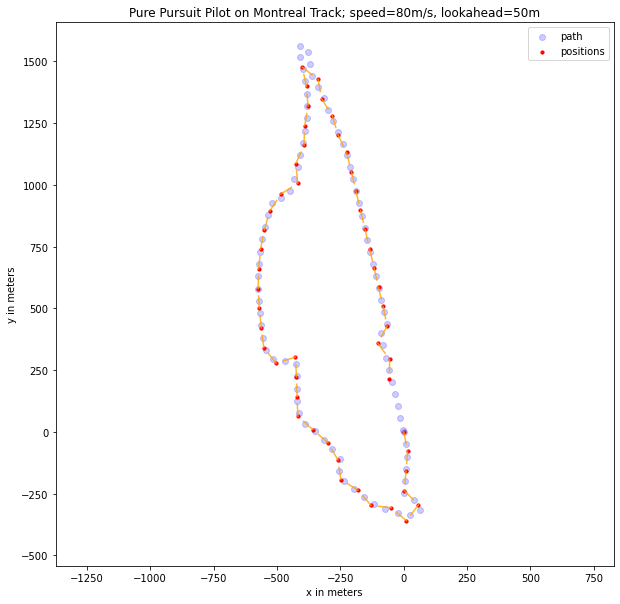

In [88]:
fig = plt.figure(figsize=(10,10))
plt.scatter([x for x,y in path], [y for x,y in path], color='blue', label='path', alpha=.2)
plt.scatter([x for x,y in positions],[y for x,y in positions], color='red', label='positions', s=10)
for i in range(50):
    plt.plot([positions[i][0], goals[i][0]], [positions[i][1], goals[i][1]], color='orange', alpha=.8)

plt.legend()
plt.xlim(x_mean - plot_width/2 - padding, x_mean + plot_width/2 + padding)
plt.ylim(y_mean - plot_width/2 - padding, y_mean + plot_width/2 + padding)
plt.xlabel('x in meters')
plt.ylabel('y in meters')
plt.title('Pure Pursuit Pilot on Montreal Track; speed=80m/s, lookahead=50m')
plt.show()

In [65]:
max([x for x,y in montreal]), min([x for x,y in montreal]), max([x for x,y in montreal]) - min([x for x,y in montreal])

(64.391684, -574.304314, 638.6959979999999)

In [66]:
max([y for x,y in montreal]), min([y for x,y in montreal]), max([y for x,y in montreal]) - min([y for x,y in montreal])

(1563.508715, -337.761783, 1901.2704979999999)

In [8]:
# limit to 1/10th points
oschersleben = []
i = 0
for line in open('Oschersleben.csv'):
    # only record 1 in 20
    if i%10 == 0:
        # x,y
        oschersleben += [(eval(line)[0], eval(line)[1])]
    i += 1

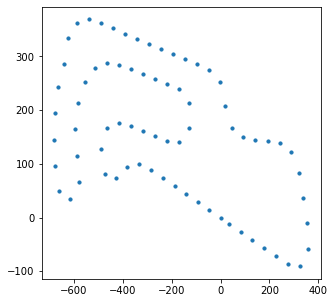

In [9]:
fig = plt.figure(figsize=(5,5))
plt.scatter([x for x,y in oschersleben],[y for x,y in oschersleben], s=10)
plt.show()

In [25]:
def plot_pursuit(path, ld, speed):
    goals = []
    throttles = [1 for point in path]
    pos_x = 0
    pos_y = 0
    heading = 0
    closest_idx = 0
    pilot = PurePursuit_Pilot(1, ld)
    positions = [(pos_x, pos_y)]
    for ip in range(len(path)):
            # if dist is lower than current, set new
            new_dist = dist(pos_x, pos_y, path[(closest_idx + ip) % len(path)][0], path[(closest_idx + ip) % len(path)][1])
            if new_dist < dist(pos_x, pos_y, path[closest_idx][0], path[closest_idx][1]):
                #print(f'new lowest dist: {new_dist}')
                closest_idx = ip
    for i in range(50):

        # run pilot to find steering angle
        goal, steer, throttle = pilot.run(path, pos_x, pos_y, heading, throttles, closest_idx)
        goals += [goal]
        #print(f'heading {heading} adjusted to {heading + steer} with steering {steer}')
        heading += steer
        #print(f'new heading {heading} adjusted to {abs(heading)}')
        #print(f'diff {old_head-abs(heading)}')
        #print('----')
        #heading = abs(heading)
        # log received
        #print(f'At ({[pos_x]}, {pos_y}), moving to {goal}, using angle {steer * (180/math.pi)}')
        # move set distance in direction
        pos_x += math.cos(heading)*speed
        pos_y += math.sin(heading)*speed
        positions += [(pos_x, pos_y)]
        # update closest_idx; only search next 3 points
        for ip in range(10):
            # if dist is lower than current, set new
            if dist(pos_x, pos_y, path[(ip + closest_idx) % len(path)][0], path[(ip + closest_idx) % len(path)][1]) < dist(pos_x, pos_y, path[closest_idx][0], path[closest_idx][1]):
                closest_idx += ip
                closest_idx %= len(path)
    x_mean = np.mean([x for x,y in path])
    x_width = max([x for x,y in path]) - min([x for x,y in path])
    y_mean = np.mean([y for x,y in path])
    y_width = max([y for x,y in path]) - min([y for x,y in path])

    plot_width = max(x_width, y_width)
    padding = 150
    
    fig = plt.figure(figsize=(15,15))
    plt.scatter([x for x,y in path], [y for x,y in path], color='blue', label='path', alpha=.2)
    plt.scatter([x for x,y in positions],[y for x,y in positions], color='red', label='positions', s=10)
    for i in range(50):
        plt.plot([positions[i][0], goals[i][0]], [positions[i][1], goals[i][1]], color='black', alpha=.2)

    plt.legend()
    plt.xlim(x_mean - plot_width/2 - padding, x_mean + plot_width/2 + padding)
    plt.ylim(y_mean - plot_width/2 - padding, y_mean + plot_width/2 + padding)
    plt.xlabel('x (meters)')
    plt.ylabel('y (meters)')
    plt.title('Pure Pursuit Pilot on Oscherslben Track; lookahead=10m')
    plt.show()

In [23]:
##### pilot for oschersleben
goals = []
path = oschersleben
throttles = [1 for point in path]
pos_x = 0
pos_y = 0
heading = 0
speed = 40
closest_idx = 0
pilot = PurePursuit_Pilot(1, 60)
positions = [(pos_x, pos_y)]
for ip in range(len(path)):
        # if dist is lower than current, set new
        new_dist = dist(pos_x, pos_y, path[(closest_idx + ip) % len(path)][0], path[(closest_idx + ip) % len(path)][1])
        if new_dist < dist(pos_x, pos_y, path[closest_idx][0], path[closest_idx][1]):
            #print(f'new lowest dist: {new_dist}')
            closest_idx = ip
print(f'closest starting point at index {closest_idx}: {path[closest_idx]}')
for i in range(32):

    # run pilot to find steering angle
    goal, steer, throttle = pilot.run(path, pos_x, pos_y, heading, throttles, closest_idx)
    goals += [goal]
    heading += steer
    print(f'new heading: {heading * (180/math.pi)}')
    # log received
    #print(f'At ({[pos_x]}, {pos_y}), moving to {goal}, using angle {steer * (180/math.pi)}')
    # move set distance in direction
    pos_x += math.cos(heading)*speed
    pos_y += math.sin(heading)*speed
    positions += [(pos_x, pos_y)]
    # update closest_idx; only search next 3 points
    for ip in range(10):
        # if dist is lower than current, set new
        if dist(pos_x, pos_y, path[(ip + closest_idx) % len(path)][0], path[(ip + closest_idx) % len(path)][1]) < dist(pos_x, pos_y, path[closest_idx][0], path[closest_idx][1]):
            closest_idx += ip
            closest_idx %= len(path)

closest starting point at index 0: (2.232642, -1.116237)
new heading: 162.61553154636522
new heading: 162.39806181922995
new heading: 162.3958410451667
new heading: 162.49579492252104
new heading: 162.64932269404815
new heading: 162.8446827898825
new heading: 163.2209908239049
new heading: 165.55687543873307
new heading: 177.3598162773273
new heading: 191.28704530329824
new heading: 190.53251401948305
new heading: 159.599243650308
new heading: 100.335551637481
new heading: 43.19348997063695
new heading: 11.082703226649588
new heading: 357.42513678363423
new heading: 351.90912800716836
new heading: 349.9493402626557
new heading: 350.22511738696517
new heading: 354.67794568357834
new heading: 11.817296752903014
new heading: 53.71551200035931
new heading: 117.674068460715
new heading: 152.61262027024236
new heading: 163.79210003994444
new heading: 167.5683231194269
new heading: 168.811306543492
new heading: 169.22093948350846
new heading: 169.6254088958654
new heading: 173.19740089222418


In [31]:
x_mean = np.mean([x for x,y in path])
x_width = max([x for x,y in path]) - min([x for x,y in path])
y_mean = np.mean([y for x,y in path])
y_width = max([y for x,y in path]) - min([y for x,y in path])

plot_width = max(x_width, y_width)
padding = 150

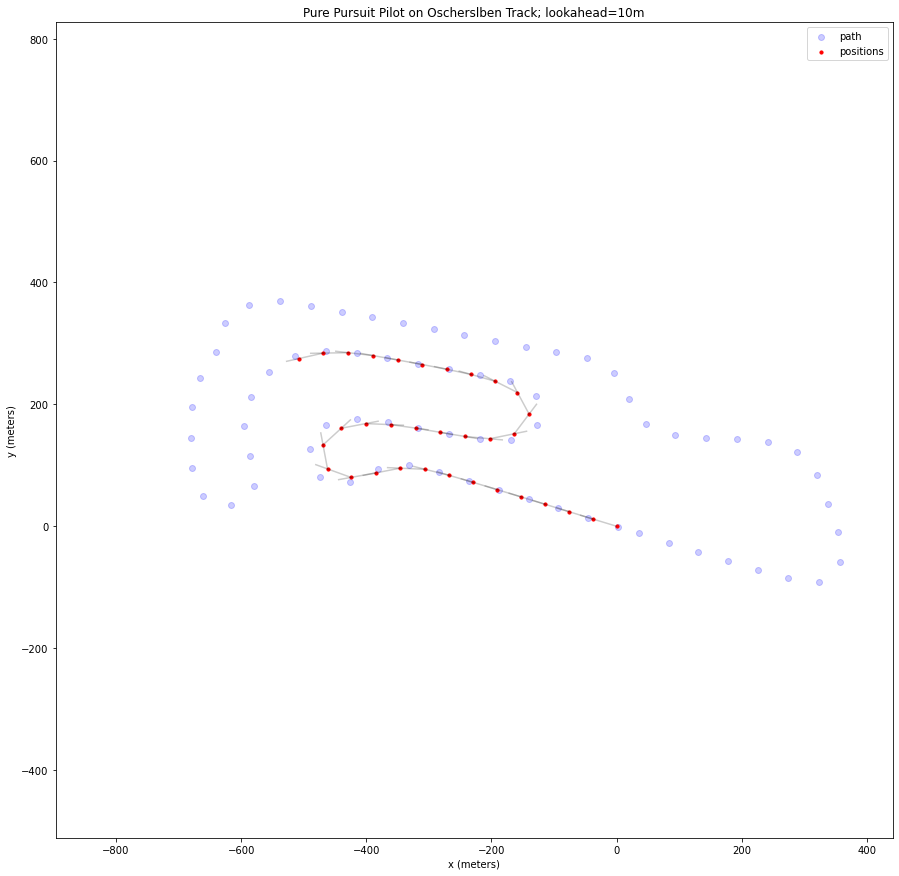

In [34]:
fig = plt.figure(figsize=(15,15))
plt.scatter([x for x,y in path], [y for x,y in path], color='blue', label='path', alpha=.2)
plt.scatter([x for x,y in positions],[y for x,y in positions], color='red', label='positions', s=10)
for i in range(32):
    plt.plot([positions[i][0], goals[i][0]], [positions[i][1], goals[i][1]], color='black', alpha=.2)

plt.legend()
plt.xlim(x_mean - plot_width/2 - padding, x_mean + plot_width/2 + padding)
plt.ylim(y_mean - plot_width/2 - padding, y_mean + plot_width/2 + padding)
plt.xlabel('x (meters)')
plt.ylabel('y (meters)')
plt.title('Pure Pursuit Pilot on Oscherslben Track; lookahead=10m')
plt.show()

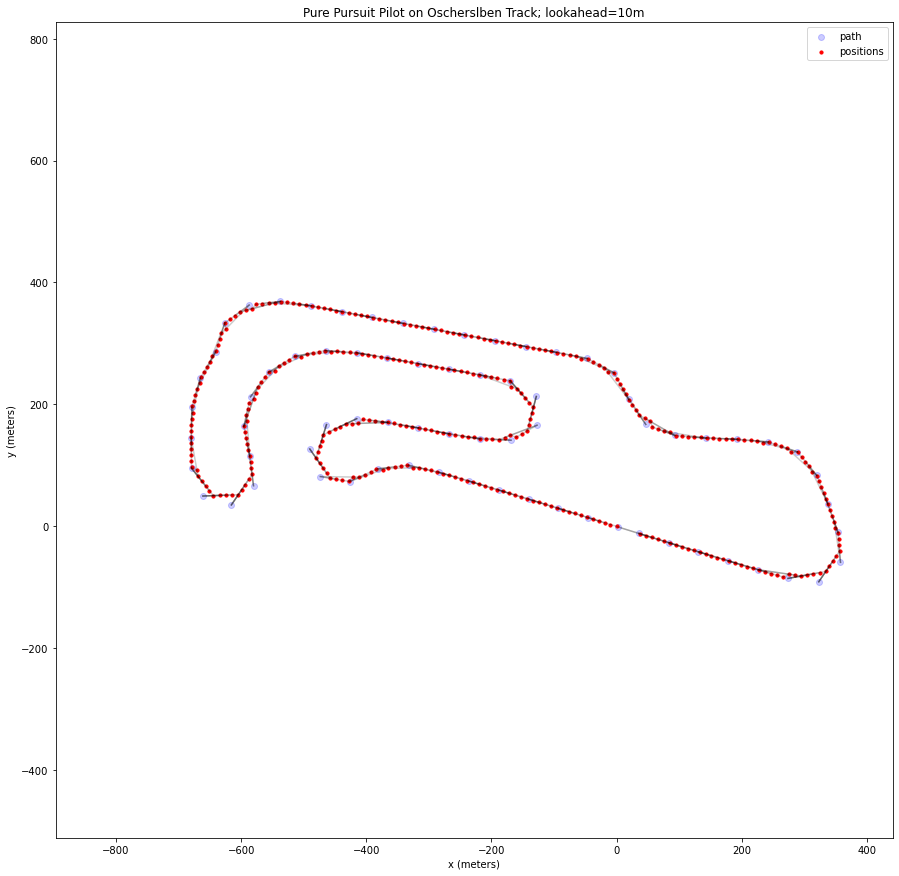

In [203]:
fig = plt.figure(figsize=(15,15))
plt.scatter([x for x,y in path], [y for x,y in path], color='blue', label='path', alpha=.2)
plt.scatter([x for x,y in positions],[y for x,y in positions], color='red', label='positions', s=10)
for i in range(350):
    plt.plot([positions[i][0], goals[i][0]], [positions[i][1], goals[i][1]], color='black', alpha=.2)

plt.legend()
plt.xlim(x_mean - plot_width/2 - padding, x_mean + plot_width/2 + padding)
plt.ylim(y_mean - plot_width/2 - padding, y_mean + plot_width/2 + padding)
plt.xlabel('x (meters)')
plt.ylabel('y (meters)')
plt.title('Pure Pursuit Pilot on Oscherslben Track; lookahead=10m')
plt.show()

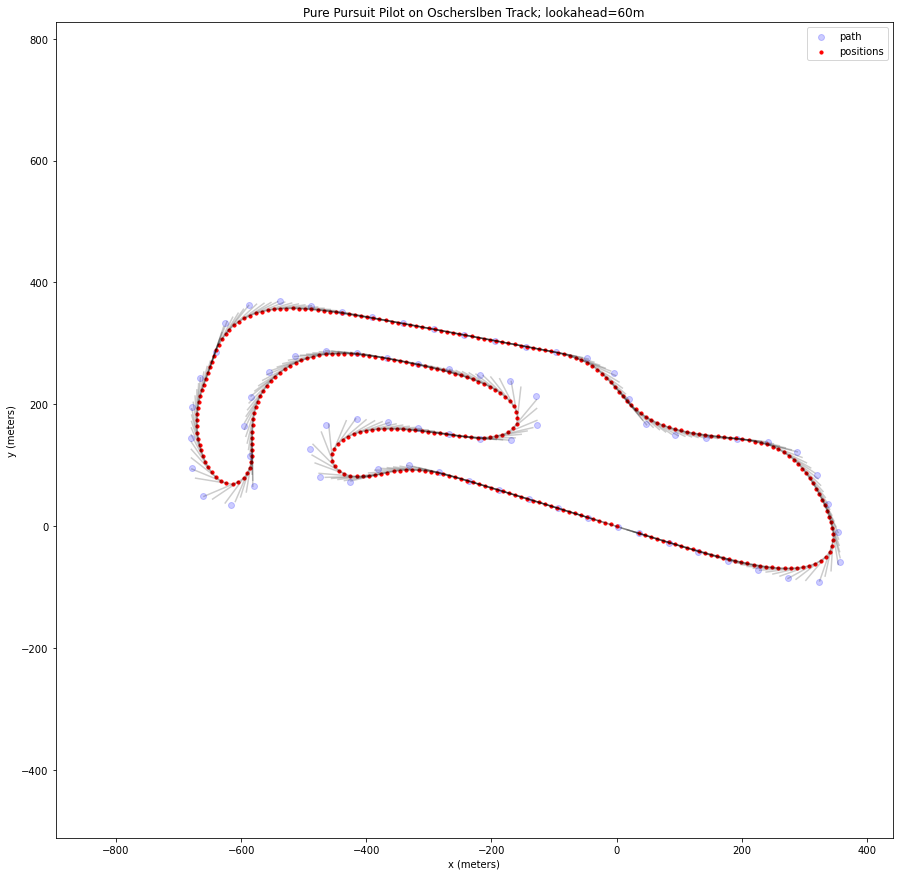

In [191]:
fig = plt.figure(figsize=(15,15))
plt.scatter([x for x,y in path], [y for x,y in path], color='blue', label='path', alpha=.2)
plt.scatter([x for x,y in positions],[y for x,y in positions], color='red', label='positions', s=10)
for i in range(320):
    plt.plot([positions[i][0], goals[i][0]], [positions[i][1], goals[i][1]], color='black', alpha=.2)

plt.legend()
plt.xlim(x_mean - plot_width/2 - padding, x_mean + plot_width/2 + padding)
plt.ylim(y_mean - plot_width/2 - padding, y_mean + plot_width/2 + padding)
plt.xlabel('x (meters)')
plt.ylabel('y (meters)')
plt.title('Pure Pursuit Pilot on Oscherslben Track; lookahead=60m')
plt.show()

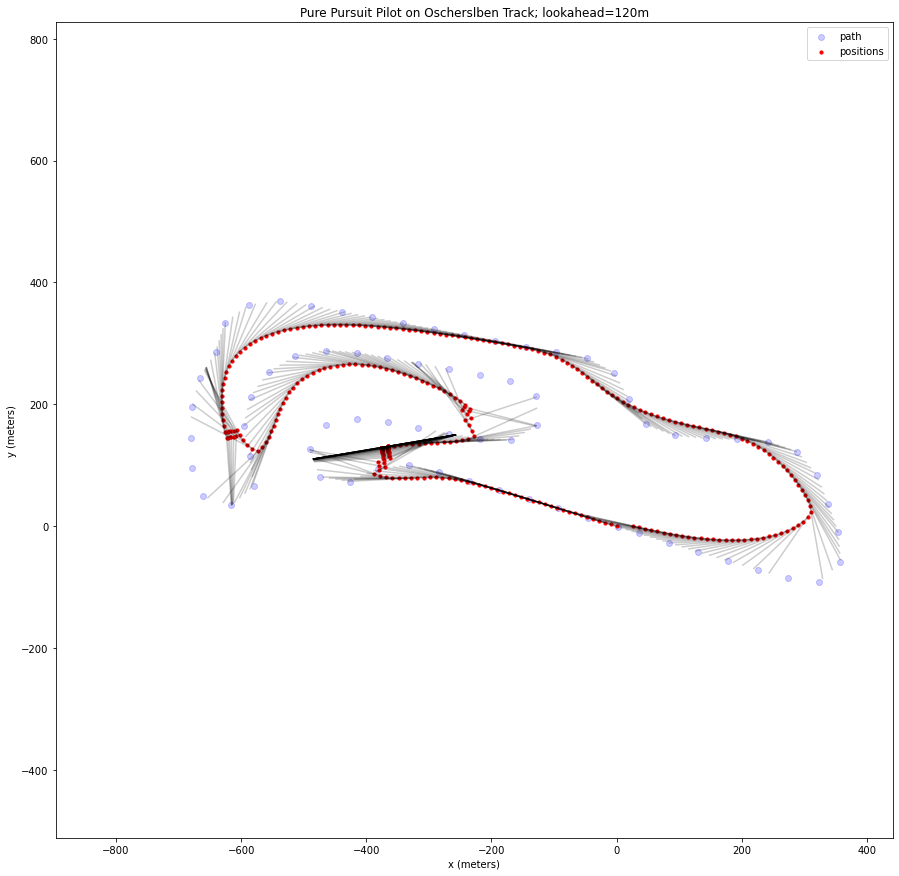

In [200]:
fig = plt.figure(figsize=(15,15))
plt.scatter([x for x,y in path], [y for x,y in path], color='blue', label='path', alpha=.2)
plt.scatter([x for x,y in positions],[y for x,y in positions], color='red', label='positions', s=10)
for i in range(350):
    plt.plot([positions[i][0], goals[i][0]], [positions[i][1], goals[i][1]], color='black', alpha=.2)

plt.legend()
plt.xlim(x_mean - plot_width/2 - padding, x_mean + plot_width/2 + padding)
plt.ylim(y_mean - plot_width/2 - padding, y_mean + plot_width/2 + padding)
plt.xlabel('x (meters)')
plt.ylabel('y (meters)')
plt.title('Pure Pursuit Pilot on Oscherslben Track; lookahead=120m')
plt.show()

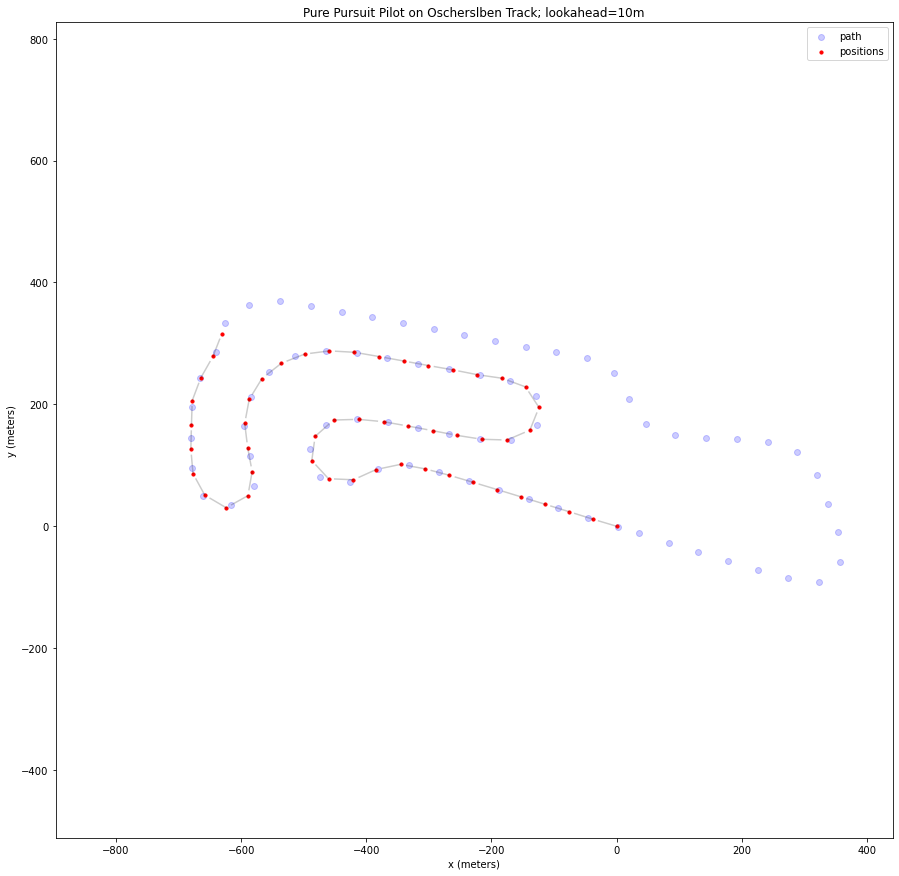

In [26]:
# path, lookahead, speed
plot_pursuit(oschersleben, 30, 40)

In [68]:
# find average dist
dists = []
for i in range(len(oschersleben) - 1):
    dists += [dist(oschersleben[i][0], oschersleben[i][1], oschersleben[i + 1][0], oschersleben[i + 1][1])]
np.mean(dists)

49.533766183159415